#Install and import dependencies

In [2]:
import glob
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None

#Clean data

In [ ]:
def load_parquet_all(path_pattern):
    files = sorted(glob.glob(path_pattern))
    if not files:
        print("No parquet files:", path_pattern)
        return pd.DataFrame()
    dfs = [pd.read_parquet(f) for f in files]
    df = pd.concat(dfs, ignore_index=True)
    return df

df = load_parquet_all("data/bronze_py/*.parquet")
print("Loaded rows:", len(df))
if df.empty:
    raise SystemExit("No data loaded. Run producer/consumer first.")

Loaded rows: 127525


In [11]:
df = df[~df.index.duplicated(keep='first')]

In [20]:
print(df)

       sensor  speed   timestamp
0       roadA     34  1762594904
1       roadB     19  1762594906
2       roadC     42  1762594908
3       roadA     55  1762594910
4       roadB     12  1762594912
...       ...    ...         ...
127520  roadC     54  1762799194
127521  roadA     16  1762799196
127522  roadC     33  1762799198
127523  roadC     40  1762799200
127524  roadB     33  1762799202

[127525 rows x 3 columns]


In [16]:
def ensure_datetime(df, ts_col='timestamp'):
    """Convert unix timestamp (seconds or ms) to pandas datetime in-place copy."""
    df = df.copy()
    max_ts = df[ts_col].max()
    unit = 'ms' if max_ts > 10**12 else 's'
    df['datetime'] = pd.to_datetime(df[ts_col], unit=unit)
    return df


In [17]:
pandas_datetime_df = ensure_datetime(df)

In [21]:
print(pandas_datetime_df)

       sensor  speed   timestamp            datetime
0       roadA     34  1762594904 2025-11-08 09:41:44
1       roadB     19  1762594906 2025-11-08 09:41:46
2       roadC     42  1762594908 2025-11-08 09:41:48
3       roadA     55  1762594910 2025-11-08 09:41:50
4       roadB     12  1762594912 2025-11-08 09:41:52
...       ...    ...         ...                 ...
127520  roadC     54  1762799194 2025-11-10 18:26:34
127521  roadA     16  1762799196 2025-11-10 18:26:36
127522  roadC     33  1762799198 2025-11-10 18:26:38
127523  roadC     40  1762799200 2025-11-10 18:26:40
127524  roadB     33  1762799202 2025-11-10 18:26:42

[127525 rows x 4 columns]


In [35]:
def aggregate(
    df,
    sensor_col='sensor',
    ts_col='timestamp',
    speed_col='speed',
    freq='5min',
    include_empty=False
):
    # named aggregation
    agg = (
        df
        .groupby([sensor_col, pd.Grouper(key='datetime', freq=freq)])[speed_col]
        .agg(
            count='count',
            median='median',
            mean='mean',
            std='std',
        )
    ).reset_index().rename(columns={'datetime':'interval_start'})
    agg['is_empty'] = agg['count'] == 0

    if include_empty:
        sensors = df[sensor_col].unique()
        start = df['datetime'].min().floor(freq)
        end = df['datetime'].max().ceil(freq)
        full_time = pd.date_range(start=start, end=end, freq=freq)
        full_index = pd.MultiIndex.from_product([sensors, full_time], names=[sensor_col, 'interval_start'])
        agg = agg.set_index([sensor_col, 'interval_start']).reindex(full_index).reset_index()
        agg['count'] = agg['count'].fillna(0).astype(int)
        agg['is_empty'] = agg['count'] == 0
    return agg.sort_values([sensor_col, 'interval_start']).reset_index(drop=True)

In [36]:
agg_df = aggregate(pandas_datetime_df, include_empty=True, freq='5min')
print(agg_df)

     sensor      interval_start  count  median       mean        std  is_empty
0     roadA 2025-11-08 09:40:00     76    35.5  35.000000  12.644894     False
1     roadA 2025-11-08 09:45:00    104    41.0  38.365385  15.328796     False
2     roadA 2025-11-08 09:50:00     88    28.0  30.636364  14.228175     False
3     roadA 2025-11-08 09:55:00     94    33.0  33.446809  13.652852     False
4     roadA 2025-11-08 10:00:00    112    30.5  31.767857  14.893001     False
...     ...                 ...    ...     ...        ...        ...       ...
2044  roadC 2025-11-10 18:10:00     58    33.5  34.310345  13.641020     False
2045  roadC 2025-11-10 18:15:00     56    36.5  36.125000  14.362910     False
2046  roadC 2025-11-10 18:20:00     53    34.0  34.603774  15.407715     False
2047  roadC 2025-11-10 18:25:00     18    34.5  34.055556  16.075089     False
2048  roadC 2025-11-10 18:30:00      0     NaN        NaN        NaN      True

[2049 rows x 7 columns]


In [37]:
clean_df = agg_df[agg_df['is_empty'] == False]
print(clean_df)

     sensor      interval_start  count  median       mean        std  is_empty
0     roadA 2025-11-08 09:40:00     76    35.5  35.000000  12.644894     False
1     roadA 2025-11-08 09:45:00    104    41.0  38.365385  15.328796     False
2     roadA 2025-11-08 09:50:00     88    28.0  30.636364  14.228175     False
3     roadA 2025-11-08 09:55:00     94    33.0  33.446809  13.652852     False
4     roadA 2025-11-08 10:00:00    112    30.5  31.767857  14.893001     False
...     ...                 ...    ...     ...        ...        ...       ...
2043  roadC 2025-11-10 18:05:00     41    34.0  33.707317  14.632573     False
2044  roadC 2025-11-10 18:10:00     58    33.5  34.310345  13.641020     False
2045  roadC 2025-11-10 18:15:00     56    36.5  36.125000  14.362910     False
2046  roadC 2025-11-10 18:20:00     53    34.0  34.603774  15.407715     False
2047  roadC 2025-11-10 18:25:00     18    34.5  34.055556  16.075089     False

[1544 rows x 7 columns]


#Feature Engineering

In [44]:
def feature_engineer(df, sensor_col='sensor', time_col='interval_start',
                    window=3, flow_thresh_per_min=5.0, encode_sensor='onehot'):

    a = df.copy()

    # 1. Ensure datetime format
    if not np.issubdtype(a[time_col].dtype, np.datetime64):
        a[time_col] = pd.to_datetime(a[time_col])

    # 2. Sort data (keeps the time series chronological)
    a = a.sort_values([sensor_col, time_col]).reset_index(drop=True)

    # 3. Time-based numeric/binary features
    a['hour'] = a[time_col].dt.hour
    a['minute'] = a[time_col].dt.minute
    a['weekday'] = a[time_col].dt.weekday  # Monday=0
    a['is_weekend'] = a['weekday'].isin([5,6]).astype(int)

    # Define night as 22:00-5:59
    a['is_night'] = ((a['hour'] >= 22) | (a['hour'] <= 5)).astype(int)

    # 4. Cyclical encodings for hour and minute
    a['hour_sin'] = np.sin(2 * np.pi * a['hour'] / 24)
    a['hour_cos'] = np.cos(2 * np.pi * a['hour'] / 24)
    a['min_sin'] = np.sin(2 * np.pi * a['minute'] / 60)
    a['min_cos'] = np.cos(2 * np.pi * a['minute'] / 60)

    # 5. Sensor encoding
    if encode_sensor == 'onehot':
        dummies = pd.get_dummies(a[sensor_col], prefix=sensor_col)
        dummies = dummies.astype(int)
        a = pd.concat([a.reset_index(drop=True), dummies.reset_index(drop=True)], axis=1)
    elif encode_sensor == 'label':
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        a[f'{sensor_col}_label'] = le.fit_transform(a[sensor_col].astype(str))
    else:
        raise ValueError("encode_sensor must be 'onehot' or 'label'")

    return a

In [45]:
new_featured_df = feature_engineer(clean_df)
print(new_featured_df)

     sensor      interval_start  count  median       mean        std  \
0     roadA 2025-11-08 09:40:00     76    35.5  35.000000  12.644894   
1     roadA 2025-11-08 09:45:00    104    41.0  38.365385  15.328796   
2     roadA 2025-11-08 09:50:00     88    28.0  30.636364  14.228175   
3     roadA 2025-11-08 09:55:00     94    33.0  33.446809  13.652852   
4     roadA 2025-11-08 10:00:00    112    30.5  31.767857  14.893001   
...     ...                 ...    ...     ...        ...        ...   
1539  roadC 2025-11-10 18:05:00     41    34.0  33.707317  14.632573   
1540  roadC 2025-11-10 18:10:00     58    33.5  34.310345  13.641020   
1541  roadC 2025-11-10 18:15:00     56    36.5  36.125000  14.362910   
1542  roadC 2025-11-10 18:20:00     53    34.0  34.603774  15.407715   
1543  roadC 2025-11-10 18:25:00     18    34.5  34.055556  16.075089   

      is_empty  hour  minute  weekday  is_weekend  is_night  hour_sin  \
0        False     9      40        5           1         0  0

In [48]:
def plot_rolling_timeseries(
    df,
    sensor_col='sensor',
    time_col='interval_start',
    value_col='median',         # speed column to plot
    resample_rule='5T',         # e.g. '1min', '5min', '30min'
    resample_agg='median',      # 'median' or 'mean'
    rolling_window=3,           # rolling mean window (points)
    interpolate=True,
    sensors=None,               # list of sensors to plot (None -> all)
    figsize=(12,5),
    title=None,
    savepath=None
):
    """
    Plot per-sensor time series: resample -> interpolate -> rolling(window).mean()
    """
    df = df.copy()
    # ensure datetime
    if not np.issubdtype(df[time_col].dtype, np.datetime64):
        df[time_col] = pd.to_datetime(df[time_col])
    # choose sensors
    if sensors is None:
        sensors = df[sensor_col].unique()
    plt.figure(figsize=figsize)
    for s in sensors:
        sub = df[df[sensor_col] == s].sort_values(time_col)
        if sub.shape[0] == 0:
            continue
        series = sub.set_index(time_col)[value_col]
        # resample
        if resample_agg == 'median':
            series = series.resample(resample_rule).median()
        elif resample_agg == 'mean':
            series = series.resample(resample_rule).mean()
        else:
            raise ValueError("resample_agg must be 'median' or 'mean'")
        # interpolate missing because resample introduces NaNs
        if interpolate:
            series = series.interpolate(method='time', limit_direction='both')
        # rolling mean
        rolling = series.rolling(window=rolling_window, min_periods=1).mean()
        plt.plot(rolling.index, rolling.values, label=str(s))
    plt.legend()
    if title is None:
        title = f"{resample_rule} resampled + {rolling_window}-period rolling {value_col}"
    plt.title(title)
    plt.xlabel("time")
    plt.ylabel(f"{value_col} (rolling mean)")
    plt.grid(True)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()


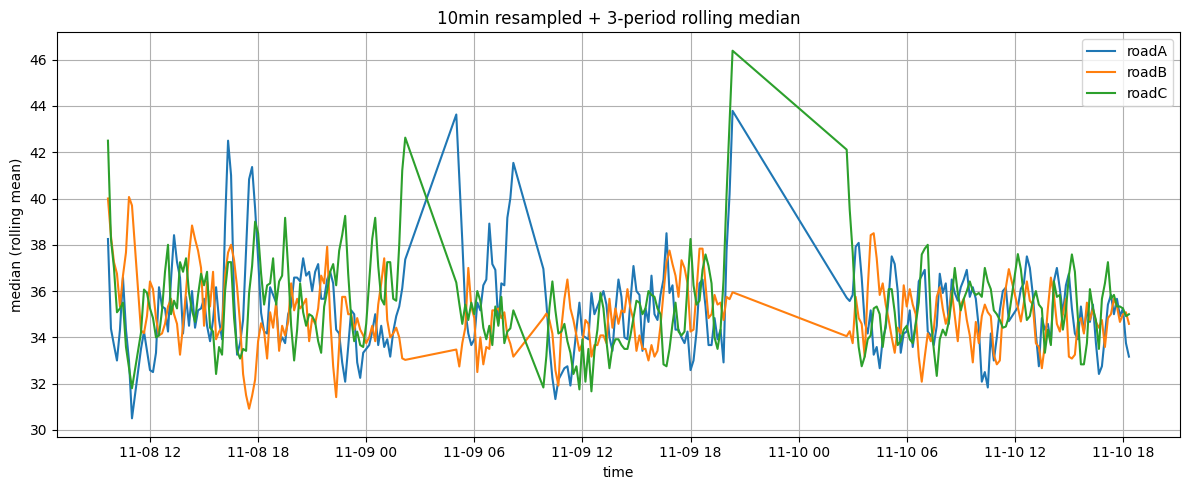

In [49]:
plot_rolling_timeseries(new_featured_df,
                       resample_rule='10min',
                       resample_agg='median',
                       rolling_window=3)


In [71]:
def append_congestion(
    df,
    sensor_col='sensor',
    time_col='interval_start',
    value_col='median',
    window=3,
    thr_low=32,   # rolling < thr_low -> level 2
    thr_mid=38    # thr_low <= rolling < thr_mid -> level 1; else 0
):

    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
        df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values([sensor_col, time_col]).reset_index(drop=True)

    # compute rolling mean per sensor (fast & simple)
    df['_rolling'] = df.groupby(sensor_col)[value_col].transform(
        lambda s: s.rolling(window=window, min_periods=1).mean()
    )

    # init congestion_level as NA where rolling is NA, else 0
    df['congestion_level'] = 1
    mask_notna = df['_rolling'].notna()
    df.loc[mask_notna, 'congestion_level'] = 0

    # apply thresholds
    df.loc[mask_notna & (df['_rolling'] < thr_low), 'congestion_level'] = 2
    df.loc[mask_notna & (df['_rolling'] >= thr_low) & (df['_rolling'] < thr_mid), 'congestion_level'] = 1

    # optional: if you want rows flagged empty (is_empty==True) to be NA (keep missing)
    if 'is_empty' in df.columns:
        df.loc[df['is_empty'] == True, 'congestion_level'] = pd.NA

    # convert to nullable Int type
    df['congestion_level'] = df['congestion_level'].astype('Int64')

    # drop helper col and return
    df = df.drop(columns=['_rolling'])
    return df

In [72]:
classified_df = append_congestion(new_featured_df)
print(classified_df)

     sensor      interval_start  count  median       mean        std  \
0     roadA 2025-11-08 09:40:00     76    35.5  35.000000  12.644894   
1     roadA 2025-11-08 09:45:00    104    41.0  38.365385  15.328796   
2     roadA 2025-11-08 09:50:00     88    28.0  30.636364  14.228175   
3     roadA 2025-11-08 09:55:00     94    33.0  33.446809  13.652852   
4     roadA 2025-11-08 10:00:00    112    30.5  31.767857  14.893001   
...     ...                 ...    ...     ...        ...        ...   
1539  roadC 2025-11-10 18:05:00     41    34.0  33.707317  14.632573   
1540  roadC 2025-11-10 18:10:00     58    33.5  34.310345  13.641020   
1541  roadC 2025-11-10 18:15:00     56    36.5  36.125000  14.362910   
1542  roadC 2025-11-10 18:20:00     53    34.0  34.603774  15.407715   
1543  roadC 2025-11-10 18:25:00     18    34.5  34.055556  16.075089   

      is_empty  hour  minute  weekday  is_weekend  is_night  hour_sin  \
0        False     9      40        5           1         0  0

In [73]:
cols_to_drop = ['sensor', 'interval_start', 'count', 'is_empty', 'hour', 'minute']

df_final = classified_df.drop(columns=cols_to_drop)

print(df_final.columns)

Index(['median', 'mean', 'std', 'weekday', 'is_weekend', 'is_night',
       'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'sensor_roadA',
       'sensor_roadB', 'sensor_roadC', 'congestion_level'],
      dtype='object')


In [74]:
print(df_final)

      median       mean        std  weekday  is_weekend  is_night  hour_sin  \
0       35.5  35.000000  12.644894        5           1         0  0.707107   
1       41.0  38.365385  15.328796        5           1         0  0.707107   
2       28.0  30.636364  14.228175        5           1         0  0.707107   
3       33.0  33.446809  13.652852        5           1         0  0.707107   
4       30.5  31.767857  14.893001        5           1         0  0.500000   
...      ...        ...        ...      ...         ...       ...       ...   
1539    34.0  33.707317  14.632573        0           0         0 -1.000000   
1540    33.5  34.310345  13.641020        0           0         0 -1.000000   
1541    36.5  36.125000  14.362910        0           0         0 -1.000000   
1542    34.0  34.603774  15.407715        0           0         0 -1.000000   
1543    34.5  34.055556  16.075089        0           0         0 -1.000000   

          hour_cos   min_sin       min_cos  sensor_

#Preparing training data and validation data

In [75]:
from sklearn.model_selection import train_test_split

X = df_final.drop(columns=['congestion_level'])
y = df_final['congestion_level']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


Train shape: (1235, 13) (1235,)
Test shape: (309, 13) (309,)


#XGBoost

In [76]:
import xgboost as xgb

In [77]:
xgb_params = {
    'eta': 0.0175,
    'max_depth': 9,
    'subsample': 0.80,
    'min_child_weight': 5,
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'lambda': 0.8,
    'alpha': 0.4,
    'base_score': np.mean(X_test),
    'device': 'cuda:0',
    'tree_method': 'hist',
    'num_parallel_tree': 3
}

num_boost_rounds = 841
model = xgb.train(
    dict(xgb_params, silent=1),
    dtrain,
    num_boost_round=num_boost_rounds,
)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:59:18] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:59:18] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:59:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [85]:
model_filename = "xgb_model.json"
model.save_model(model_filename)
print(f"Model saved as {model_filename}")

Model saved as xgb_model.json


In [86]:
loaded_model = xgb.Booster()

loaded_model.load_model("xgb_model.json")
print("Model loaded successfully!")

Model loaded successfully!


In [88]:
import pandas as pd
import numpy as np
import xgboost as xgb

# 1. Define the current scenario (Facts)
# Let's say we just got a reading from Road A's sensor
current_stats = {
    'median': 38.0,
    'mean': 37.2,
    'std': 12.5,
    'weekday': 4,       # Friday
    'is_weekend': 0,
    'is_night': 0,
    'hour_sin': np.sin(2 * np.pi * 15 / 24), # 3 PM
    'hour_cos': np.cos(2 * np.pi * 15 / 24),
    'min_sin': np.sin(2 * np.pi * 30 / 60),  # 30 minutes
    'min_cos': np.cos(2 * np.pi * 30 / 60),
    'sensor_roadA': 1,  # It is Road A
    'sensor_roadB': 0,
    'sensor_roadC': 0
}

new_data = pd.DataFrame([current_stats])[X.columns]

dnew = xgb.DMatrix(new_data)

prediction = loaded_model.predict(dnew)
print(f"Predicted Congestion Level: {prediction[0]:.2f}")
print(f"Rounded Level: {int(np.round(prediction[0]))}")

Predicted Congestion Level: 0.66
Rounded Level: 1


#Evaluation

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support, confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.multiclass import unique_labels
from scipy.stats import spearmanr
from sklearn.metrics import cohen_kappa_score



In [79]:
def _to_class(preds, classes=None):
    cls = np.rint(preds).astype('int')
    if classes is not None:
        mn, mx = min(classes), max(classes)
        cls = np.clip(cls, mn, mx)
    else:
        # enforce non-negative
        cls = np.clip(cls, 0, np.max(cls))
    return cls

In [82]:
def evaluate_xgb(
    model,
    X,
    y_true,
    dataset_name='test',
    as_regression=True,
    classes=(0,1,2),
    plot_cm=True,
    return_preds=False
):
    try:
        # model.predict accepts DMatrix or raw arrays
        preds_cont = model.predict(X)
    except Exception as e:
        # fallback: if X is DataFrame/ndarray it's fine; else try X.values
        preds_cont = model.predict(getattr(X, "values", X))
    preds_cont = np.array(preds_cont).reshape(-1)

    # Convert to discrete classes
    preds_cls = _to_class(preds_cont, classes=classes)

    # If y_true may not be ints, convert
    y_true_arr = np.array(y_true).astype('int')

    # Classification metrics
    acc = accuracy_score(y_true_arr, preds_cls)
    bal_acc = balanced_accuracy_score(y_true_arr, preds_cls)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true_arr, preds_cls, average='macro', zero_division=0
    )
    precision_weight, recall_weight, f1_weight, _ = precision_recall_fscore_support(
        y_true_arr, preds_cls, average='weighted', zero_division=0
    )
    prf_per_class = precision_recall_fscore_support(y_true_arr, preds_cls, average=None, zero_division=0)

    # Confusion matrix
    labels_sorted = np.array(sorted(list(classes)))
    cm = confusion_matrix(y_true_arr, preds_cls, labels=labels_sorted)

    # Cohen's kappa and Quadratic Weighted Kappa (weights='quadratic')
    kappa = cohen_kappa_score(y_true_arr, preds_cls, weights=None)           # linear/unweighted
    qwk = cohen_kappa_score(y_true_arr, preds_cls, weights='quadratic')     # quadratic weighted kappa

    # Spearman rank correlation between true and continuous preds
    try:
        rho, rho_p = spearmanr(y_true_arr, preds_cont)
    except Exception:
        rho, rho_p = (np.nan, np.nan)

    # Classification report text
    cls_report = classification_report(y_true_arr, preds_cls, labels=labels_sorted, zero_division=0)

    # Build results dict
    results = {
        'dataset': dataset_name,
        # classification
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weight,
        'recall_weighted': recall_weight,
        'f1_weighted': f1_weight,
        'cohen_kappa': kappa,
        'qwk': qwk,
        'spearman_rho': rho,
        'spearman_p': rho_p,
        'confusion_matrix': cm,
        'labels': labels_sorted,
        'classification_report': cls_report
    }

    # Print summary
    print(f"=== Evaluation on {dataset_name} ===")
    print(f"Classification (after rounding): Acc={acc:.4f}, BalancedAcc={bal_acc:.4f}, F1_macro={f1_macro:.4f}, QWK={qwk:.4f}")
    print()
    print("Classification report:\n", cls_report)
    print("Confusion matrix (rows=true, cols=pred) with labels:", labels_sorted)
    print(cm)
    print()

    # Plot confusion matrix
    if plot_cm:
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels_sorted, yticklabels=labels_sorted)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion matrix ({dataset_name})")
        plt.show()

    if return_preds:
        return results, preds_cont, preds_cls
    return results


=== Evaluation on Test set ===
Classification (after rounding): Acc=0.8447, BalancedAcc=0.4178, F1_macro=0.4361, QWK=0.2219

Classification report:
               precision    recall  f1-score   support

           0       0.43      0.24      0.31        25
           1       0.87      0.97      0.91       263
           2       0.50      0.05      0.09        21

    accuracy                           0.84       309
   macro avg       0.60      0.42      0.44       309
weighted avg       0.81      0.84      0.81       309

Confusion matrix (rows=true, cols=pred) with labels: [0 1 2]
[[  6  19   0]
 [  8 254   1]
 [  0  20   1]]



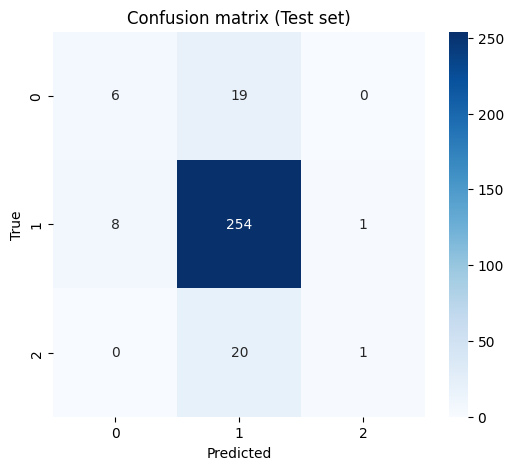

In [84]:
results = evaluate_xgb(model, dtest, y_test, dataset_name='Test set')